# GPS Tracker

This program reads a gpx file containing a series of waypoints (time, latitude, longitude, elevation) in xml format. Since I wrote the program to evaluate gpx files of runs (recorded with the Runkeeper app), each gpx track will be refered to as a <i>run</i> and some of the nomenclature was chosen with that in mind. The program then extracts some metrics of the run:
<ul>
    <li>Total distance</li>
    <li>Total time</li>
    <li>Average pace</li>
    <li>Total climb</li>
</ul>
Additionally, the program will make a series of plots to visualize the run:
<ul>
    <li>Elevation profile</li>
    <li>Pace over time</li>
    <li>Map with elevation colorcode</li>
    <li>Map with pace colorcode</li>
</ul>
First, we import some modules:

In [1]:
import pandas as pd
import numpy as np
import gpxpy
import gpxpy.gpx
import geopy.distance
from time import strftime
import matplotlib.pyplot as plt
import copy
from matplotlib.cm import terrain # import color map
from matplotlib.cm import cool # import color map
import ipyleaflet as lf

## Loading gpx file
The function load_run_to_df(filename) uses the the <b>gpxpy</b> module to read the specified gpx file into a Pandas DataFrame with four columns (time, latitude, longitude, elevation). It then adds a fifth column with the accumulated distance (which is calculated using the <b>geopy</b> module. The DataFrame with five columns is returned.

In [2]:
# Loads gpx file and returns data frame run
def load_run_to_df(filename): 
    
    # Load file into run_data using gpxpy
    with open(filename) as f:
        run_data = gpxpy.parse(f)
    f.closed
    
    # Initialize DataFrames
    df_dict = {'time': [],'lat': [],'lon': [],'elev': []}
    df = pd.DataFrame(df_dict)
    
    
    # Create DataFrame containing time, latitude, longitude, elevation columns
    for track in run_data.tracks:
        for segment in track.segments:
            for point in segment.points:
                df_newRow = pd.DataFrame([[point.time, point.latitude, point.longitude, point.elevation]], columns=['time','lat','lon','elev'])
                df = df.append(df_newRow, ignore_index=True)
                
    # Create additional column for accumulative distance
    tmp = [0]
    for i, row in df[1:].iterrows():
        prevCoord = (df.iloc[i-1]['lat'],df.iloc[i-1]['lon'])
        currCoord = (df.iloc[i]['lat'],df.iloc[i]['lon'])
        tmp.append(tmp[-1] + geopy.distance.vincenty(prevCoord, currCoord).mi)
    df['accuDist']=tmp
    
    return df

In [3]:
df = load_run_to_df('2018-03-04-070016.gpx')
df.head()

,elev,lat,lon,time,accuDist
0,150.0,37.682118,-121.768362,2018-03-04 15:00:16,0.000000
1,149.9,37.682194,-121.768297,2018-03-04 15:00:19,0.006338
2,149.9,37.682286,-121.768219,2018-03-04 15:00:24,0.013988
3,149.9,37.682363,-121.768146,2018-03-04 15:00:28,0.020638
4,149.9,37.682440,-121.768042,2018-03-04 15:00:32,0.028428


## Extract run metrics
Having already calculated the accumulated distance for each point when we loaded the file, it is straighforward to read the total distance off the last entry of the DataFrame.

In [4]:
# Calculate total distance of this run
total_distance = df.iloc[-1]['accuDist']    
print('Total distance: \t%.2f mi' % total_distance)

Total distance: 	13.23 mi


The total time is taken from the difference of the first and last timestamps. The resulting timedelta object is converted to a formatted string using the function strfdelta.

In [5]:
# Calculate total time of this run
def strfdelta(tdelta, fmt): # Reformats timedelta object to h:mm:ss
    d = {"days": tdelta.days}
    d["hours"], rem = divmod(tdelta.seconds, 3600)
    d["minutes"], d["seconds"] = divmod(rem, 60)
    return fmt.format(**d)

total_time = df.iloc[-1]['time']-df.iloc[0]['time'] # creates timedelta object

print('Total time: \t%s' % strfdelta(total_time, "{hours}:{minutes}:{seconds}"))

Total time: 	1:38:17


The average pace is calculated from the above timedelta object and the total distance and formatted as min:sec per mile.

In [6]:
# Calculate average pace
avg_pace = total_time.seconds / total_distance
avg_pace_min, avg_pace_sec = divmod(avg_pace, 60)
print('Average pace: \t%d:%d per mi' % (avg_pace_min, avg_pace_sec))

Average pace: 	7:25 per mi


The total climb is the accumulated elevation difference of all intervals between two consecutive waypoints with a positive incline. That mean we are adding up the uphill elevation differences, but do not subtract downhill parts.

In [7]:
# Calculate total climb as sum of positive inclines between two waypoints
total_climb=0
for i, row in df[1:].iterrows():
    height_difference = 3.28084*(df.iloc[i]['elev'] - df.iloc[i-1]['elev'])
    if height_difference>0:
        total_climb += height_difference

print('Total climb: \t%.1f' % total_climb)

Total climb: 	452.8


## Visualize the run
First we plot an elevtion profile as a function of distance using matplotlib. This is where our additional DataFrame column containing the accumulated distance comes in handy.

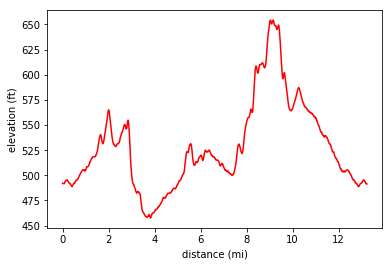

In [8]:
# Plot height profile and calculate total climb
plt.plot(df['accuDist'],3.28084*df['elev'], 'r')
plt.ylabel('elevation (ft)')
plt.xlabel('distance (mi)')
plt.show()

Next we want to make a plot showing the current pace as a function of distance. The is a little more involved than the elevation profile because the current pace is not readiy available in the DataFrame. First we calculate the pace for each interval between two waypoints (that's pace_hist). 

Since the waypoints are only a few seconds apart, the data a very noisy (you can tell from the grey trace in the below plot). We reduce the noise by removing spikes and taking a running average using numpy's convolve method. These data are shown as a red trace in the plot (the remaining spikes are real: I did actually slow down). The blue line indicates the average pace of the whole run.

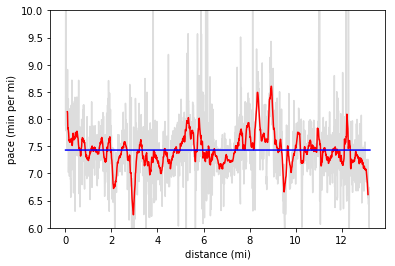

In [14]:
# Calculate current pace

# pace_hist is a list of paces between two points each
pace_hist=[]
for i, row in df[1:].iterrows():
    time_diff = df.iloc[i]['time']-df.iloc[i-1]['time']
    pos_diff  = df.iloc[i]['accuDist']-df.iloc[i-1]['accuDist']
    curr_pace = time_diff.seconds / pos_diff
    pace_hist.append(curr_pace/60)
    
# remove spikes (if a value is more than spike_tolerace times larger than the mean of the surrounding values)
spike_tolerance = 1.3
pace_hist_nospikes = copy.copy(pace_hist)
for i in range(len(pace_hist_nospikes)):
    if i>1 and i<(len(pace_hist_nospikes)-2):
        if pace_hist_nospikes[i] > spike_tolerance * np.mean([pace_hist_nospikes[i-2],pace_hist_nospikes[i-1],pace_hist_nospikes[i+1],pace_hist_nospikes[i+2]]):
            pace_hist_nospikes[i] = np.mean([pace_hist_nospikes[i-2],pace_hist_nospikes[i+2]])
        
        
# running average of pace (without spikes), N is width of average    
N = 23 # N must be 2n+1
pace_hist_binned = np.convolve(pace_hist_nospikes, np.ones((N,))/N, mode='valid')
    
# Plot original pace trace in grey and spike-removed, averaged trace in red
plt.plot(df['accuDist'][1:],pace_hist,'#dddddd')
plt.plot(df['accuDist'][1+int((N-1)/2):-int((N-1)/2)],pace_hist_binned,'r')
plt.plot(df['accuDist'][1:],[avg_pace/60 for i in range(len(df['accuDist'][1:]))],'b')
plt.ylabel('pace (min per mi)')
plt.xlabel('distance (mi)')
plt.ylim(6,10)
#plt.xlim(2,4)
plt.show()


It's interesting to note that the average pace is substantially influenced by the 'slow' spikes!

Next, we plot a map of the run in which the local elevation is represented by a color map. This allows us to locate uphill and downhill portions of the run.

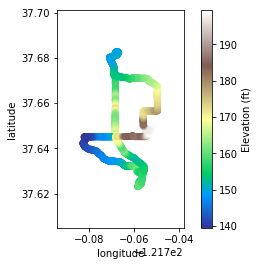

In [10]:
# Plot running path
plt.scatter(df['lon'],df['lat'],c=df['elev'], cmap=terrain)
plt.gca().set_aspect('equal', adjustable='box')
plt.colorbar().set_label('Elevation (ft)')
plt.xlabel('longitude')
plt.ylabel('latitude')
#plt.rcParams["figure.figsize"] = (10,10)
plt.show()

## Visualizing the run in a map
We can also plot the run's gps trace on a map using the ipyleaflet module.

In [11]:
center = [df['lat'].mean(),df['lon'].mean()]
zoom = 13

# Create map object
m = lf.Map(default_tiles=lf.TileLayer(opacity=1.0), center=center, zoom=zoom)

# Define start and end markers
marker_start = lf.Marker(location=[df.loc[0,'lat'],df.loc[0,'lon']])
marker_end = lf.Marker(location=[np.array(df['lat'])[-1],np.array(df['lon'])[-1]])
m += marker_start
m += marker_end

# Define polyline of run trace
run_line = list(zip(*np.array(df[['lat', 'lon']]).T))
pl = lf.Polyline(locations=run_line, fill_opacity=0)
m += pl

m

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

Instead of representing the running path with just a blue polyline, we can add more information by color-coding the running path. In this following example, the running path is visualized with markers, the color of which represents the local elevation. This gives us a sense of the terrain.

In [21]:
center = [df['lat'].mean(),df['lon'].mean()]
zoom = 13

# Create map object
m = lf.Map(default_tiles=lf.TileLayer(opacity=1.0), center=center, zoom=zoom)

# Define start and end markers
marker_start = lf.Marker(location=[df.loc[0,'lat'],df.loc[0,'lon']])
marker_end = lf.Marker(location=[np.array(df['lat'])[-1],np.array(df['lon'])[-1]])
m += marker_start
m += marker_end

# Scatter of run trace
run_line = list(zip(*np.array(df[['lat', 'lon']]).T))
circles = []

for wpt in run_line[::10]:

    # Determine index in df['elev'] that corresponds to the current waypoint
    index = int( run_line.index(wpt) / len(run_line) * len(df['elev']) )
    if index > len(df['elev']): index = 0    
    
    # Normalize elevation to value between 0 and 1
    min_val, max_val = df['elev'].min(), df['elev'].max()
    elev_percentage = (df.loc[index,'elev']-min_val ) / (max_val - min_val)
    
    # Get corresponding value from colormap
    rgb_exp =elev_percentage
    rgb=[0,0,0]
    for i in range(3): rgb[i] = int(terrain(rgb_exp)[i]*255)
    color_hex = "#%02x%02x%02x" % (rgb[0], rgb[1], rgb[2])
    
    # Add circle to map
    c = lf.Circle(location=wpt, weight=1, fill_opacity=1.0, radius=60, color='black', fill_color=color_hex)
    circles.append(c)
    m.add_layer(c)

m

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

We could also use color to represent the current pace and see where I got slower and faster, respectively.

In [20]:
center = [df['lat'].mean(),df['lon'].mean()]
zoom = 13

# Create map object
m = lf.Map(default_tiles=lf.TileLayer(opacity=1.0), center=center, zoom=zoom)

# Define start and end markers
marker_start = lf.Marker(location=[df.loc[0,'lat'],df.loc[0,'lon']])
marker_end = lf.Marker(location=[np.array(df['lat'])[-1],np.array(df['lon'])[-1]])
m += marker_start
m += marker_end

# Scatter of run trace
run_line = list(zip(*np.array(df[['lat', 'lon']]).T)) # list of corrdinates
circles = []

for wpt in run_line[::10]:
    
    # Determine index in pace_hist_binned that corresponds to the current waypoint
    index = int( run_line.index(wpt) / len(run_line) * len(pace_hist_binned) )
    if index > len(pace_hist_binned): index = 0

    # Normalize pace to value between 0 and 1 (bounds are defined via percentiles)
    min_val, max_val = np.percentile(pace_hist_binned, 5), np.percentile(pace_hist_binned, 95)
    pace_percentage = (pace_hist_binned[index]-min_val) / ( max_val - min_val)
    
    # Get corresponding value from colormap
    rgb_exp = 1 - pace_percentage # invert color map
    rgb=[0,0,0]
    for i in range(3): rgb[i] = int(cool(rgb_exp)[i]*255)
    color_hex = "#%02x%02x%02x" % (rgb[0], rgb[1], rgb[2])
    
    # Add circle to map
    c = lf.Circle(location=wpt, weight=1, fill_opacity=1.0, radius=60, color='black', fill_color=color_hex)
    circles.append(c)
    m.add_layer(c)

m

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

In addition to color representing elevation, we can also use variable marker sizes to represent pace (where larger radii indicate slower pace). Combining this information we draw the unsurprising conclusion that I got slower running uphill and faster running downhill.

In [30]:
center = [df['lat'].mean(),df['lon'].mean()]
zoom = 13

# Create map object
m = lf.Map(default_tiles=lf.TileLayer(opacity=1.0), center=center, zoom=zoom)

# Define start and end markers
marker_start = lf.Marker(location=[df.loc[0,'lat'],df.loc[0,'lon']])
marker_end = lf.Marker(location=[np.array(df['lat'])[-1],np.array(df['lon'])[-1]])
m += marker_start
m += marker_end

# Scatter of run trace
run_line = list(zip(*np.array(df[['lat', 'lon']]).T)) # list of corrdinates
circles = []

for wpt in run_line[::10]:
    
    # Determine index in pace_hist_binned that corresponds to the current waypoint
    index = int( run_line.index(wpt) / len(run_line) * len(pace_hist_binned) )
    if index > len(pace_hist_binned): index = 0

    # Normalize pace to value between 0 and 1 (bounds are defined via percentiles)
    min_val, max_val = np.percentile(pace_hist_binned, 5), np.percentile(pace_hist_binned, 95)
    pace_percentage = (pace_hist_binned[index]-min_val) / ( max_val - min_val)
    pace_radius = 40 + (pace_percentage) * 80
    
    # Determine index in df['elev'] that corresponds to the current waypoint
    index_elev = int( run_line.index(wpt) / len(run_line) * len(df['elev']) )
    if index_elev > len(df['elev']): index_elev = 0    
    
    # Normalize elevation to value between 0 and 1
    min_val_elev, max_val_elev = df['elev'].min(), df['elev'].max()
    elev_percentage = (df.loc[index_elev,'elev']-min_val_elev ) / (max_val_elev - min_val_elev)

    
    # Get corresponding value from colormap
    rgb_exp = elev_percentage # invert color map
    rgb=[0,0,0]
    for i in range(3): rgb[i] = int(terrain(rgb_exp)[i]*255)
    color_hex = "#%02x%02x%02x" % (rgb[0], rgb[1], rgb[2])
    
    # Add circle to map
    c = lf.Circle(location=wpt, weight=1, fill_opacity=1.0, radius=int(pace_radius), color='black', fill_color=color_hex)
    circles.append(c)
    m.add_layer(c)

m

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …